In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib.pyplot       as plt
import matplotlib.colors       as mcolors
import matplotlib.patches      as mpatches
import matplotlib.transforms   as mtransforms
import matplotlib.font_manager as font_manager
%matplotlib inline

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [4]:
# Imagine we have a series of diffraction image (like a video clip) to process
Tx, Cx, Hx, Wx = 5000, 1, 129, 129
video_clip = torch.randn(Tx, Cx, Hx, Wx).to(device)


In [18]:
# Chop up the video clip in spatial (Cx, Hx, Wx) and temporal (Tx) dimensions
# - spatial: 1x3x3
# - temporal: 1
ndiv = 3
tdiv = 10
Tp, Cp, Hp, Wp = Tx//tdiv, Cx, Hx // ndiv, Wx // ndiv
# video_clip_tokenized = video_clip.view(Tp, tdiv, Cp, ndiv, Hp, ndiv, Wp).transpose(-2, -3).transpose(1, 3).transpose(2, 4)

In [24]:
video_clip_tokenized = video_clip.view(Tp, tdiv, Cp, ndiv, Hp, ndiv, Wp)
video_clip_tokenized = video_clip_tokenized.transpose(-2, -3).contiguous()
video_clip_tokenized = video_clip_tokenized.transpose(1, 3).contiguous()
video_clip_tokenized = video_clip_tokenized.transpose(2, 4).contiguous()

In [25]:
video_clip_tokenized.shape

torch.Size([500, 3, 3, 10, 1, 43, 43])

In [7]:
# Create a simple 2D object (a circle in this case)
x = torch.linspace(-50, 50, 400)
y = torch.linspace(-50, 50, 400)
X, Y = torch.meshgrid(x, y)
Z = torch.sqrt(X**2 + Y**2)
circle = torch.where(Z <= 30, 1, 0)

ndiv = 4
H_cir, W_cir = circle.shape
H_tok, W_tok = H_cir // ndiv, W_cir // ndiv
circle_tokenized = circle.view(ndiv, H_tok, ndiv, W_tok).permute(0, 2, 1, 3)    # Partition an image 
                                                                                # Only the adjeact dimension can be separated or combined:
                                                                                # (H, ) = (3, H//3)
                                                                                # (W, ) = (3, W//3)
                                                                                # (H, W) = (3, H//3, 3, W//3)

/cds/sw/package/conda_envs/cwang31/peaknet-1.0/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1635005512693/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


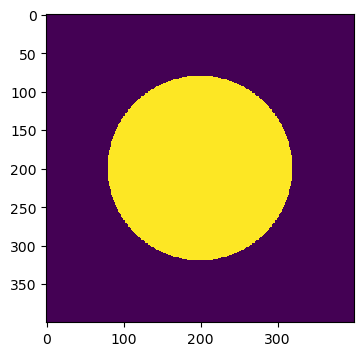

In [8]:
fig = plt.figure(figsize = (4, 4))
plt.imshow(circle, interpolation = 'none')

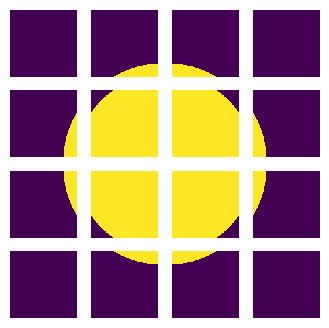

In [9]:

ncols = 4
nrows = 4
fig   = plt.figure(figsize = (4,4))
gspec = fig.add_gridspec( nrows, ncols, )
ax_list = [ fig.add_subplot(gspec[i, j], aspect = 1) for i in range(nrows) for j in range(ncols)]

for row in range(nrows):
    for col in range(ncols):
        idx = col + ncols * row
        ax = ax_list[idx]
        data = circle_tokenized[row][col]
        ax.imshow(data, interpolation = 'none')

# Apply style...
for ax in ax_list:
    ax.set_xticks([])
    ax.set_yticks([])

    # Hide the frame box
    ax.spines['top'   ].set_visible(False)
    ax.spines['right' ].set_visible(False)
    ax.spines['left'  ].set_visible(False)
    ax.spines['bottom'].set_visible(False)

In [30]:
# Linear project to encode an object as a token
Dz = 32
tokenize_layer = nn.Linear(tdiv * Cp * Hp * Wp, Dz).to(device)

In [32]:
sum(p.numel() for p in tokenize_layer.parameters())/1e6    # M parameters

0.591712

In [28]:
video_clip_tokenized.shape

torch.Size([500, 3, 3, 10, 1, 43, 43])

In [45]:
one_piece = video_clip_tokenized[0, 0, 0]
tokenize_layer(one_piece.view(-1))

tensor([ 0.7724,  0.5484, -0.7720,  0.2938, -0.4160, -0.5704, -0.7403, -1.2842,
         0.1559, -0.7766, -0.1549, -0.4446,  0.0614,  0.3793,  0.0645,  0.4157,
        -0.3775,  0.5131,  0.3660, -0.4129,  0.1970,  0.1140,  0.4844,  0.7657,
         0.5203, -0.6555, -0.2248, -0.5753,  0.1110,  0.0471,  0.4153,  0.0876],
       device='cuda:0', grad_fn=<AddBackward0>)

In [36]:
one_piece = video_clip_tokenized[0, 0, 0]
print(one_piece.view(-1))

one_token = tokenize_layer(one_piece.view(-1))
print(one_token.shape)

tensor([-0.3443, -1.1201, -0.0334,  ..., -1.0652,  0.5107, -0.1267],
       device='cuda:0')
torch.Size([32])


In [38]:
Tz, Hz, Wz, Tp, Cp, Hp, Wp = video_clip_tokenized.shape

video_token = tokenize_layer(video_clip_tokenized.view(Tz * Hz * Wz, Tp * Cp * Hp * Wp))

In [43]:
video_token = video_token.view(Tz, Hz, Wz, -1)

In [44]:
video_token.shape

torch.Size([500, 3, 3, 32])